In [1]:
import pandas as pd
import os
import numpy as np
import statistics
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import ast

os.chdir("./../..")
print(os.getcwd())


/home/gabri/Desktop/ADA/ada-2024-project-theadacuates


# Load data

In [2]:
df_paths = pd.read_csv("data/output/processed_data/all_articles_processed.csv")

df_paths['path'] = df_paths['path'].str.split(';')

df_pf = df_paths.loc[df_paths["finished"] == True]
df_uf = df_paths.loc[df_paths["finished"] == False]

cols_to_convert = ["path_list", "path_list_id", "resolved_path_list_id", "resolved_path_list_name"]

for col in cols_to_convert:
    df_paths[col] = df_paths[col].apply(ast.literal_eval)

df_names = pd.read_csv("data/output/processed_data/articles_processed.csv")

df_paths.head(2)

/tmp/ipykernel_457358/1178644881.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv("data/output/processed_data/all_articles_processed.csv")


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,"[14th century, 15th century, 16th century, Pac...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,"[14th century, Europe, Africa, Atlantic slave ...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","[14th century, Europe, Africa, Atlantic slave ..."


# Semantic similarity with transformers

We will now analyse the paths using semantic similary with SentenceTransmormer, which allows us to convert text to multidimensional vectors that can then be compared by taking the angle between vectors.

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

model.similarity_fn_name = "cosine" # valid options are “cosine”, “dot”, “euclidean”, and "manhattan"

/home/gabri/mambaforge/envs/ada/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-11-08 16:14:22.409369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 16:14:22.549886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 16:14:22.609635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has a

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

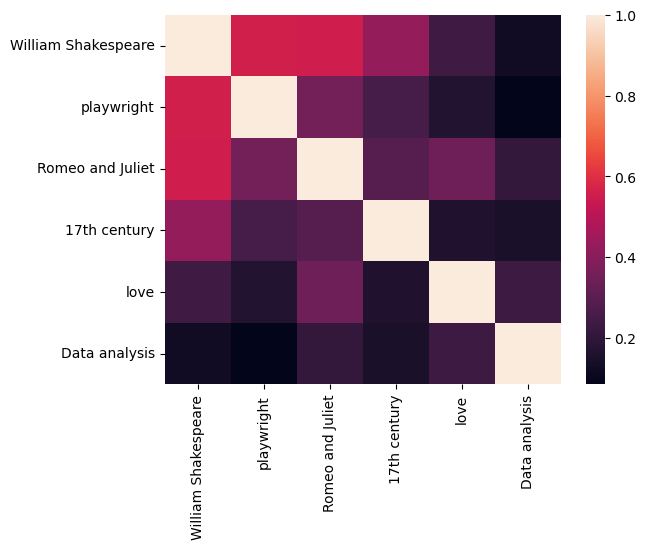

In [4]:
examples1 = ["William Shakespeare", "playwright", "Romeo and Juliet", "17th century", "love", "Data analysis"]
embeddings1 = model.encode(examples1)

similarities = model.similarity(embeddings1, embeddings1)
similarities = pd.DataFrame(similarities)
similarities.columns = examples1
similarities.index = examples1

sns.heatmap(similarities)
plt.show()

This is an example to show the semantic similarity at work. The results obtained are about what we would expect, William Shakespeare being semantically close to playwright, or Romeo and Juliet, but having nothing to do with Data analysis. We can start to see how this could be used to analyse similarity between articles. Obviously this isn't perfect as it doesn't work for more complex relationships such as between "Romeo and Juliet" and "love" which one could expect to be closely related.

In [6]:
similarity_matrix_path = "data/output/semantic_similarity_data/similarity_matrix.csv"

def clamp(n, min, max): 
    if n < min: 
        return min
    elif n > max: 
        return max
    else: 
        return n 

if not os.path.exists(similarity_matrix_path):
    embeddings = model.encode(df_names["article_name"])
    num_articles = len(embeddings)
    matrix = np.zeros(shape=(num_articles, num_articles))

    for i in range (0, num_articles):
        similarities = model.similarity([embeddings[i]], embeddings[0:(i+1)])[0]
        for j in range(0, i+1):
            similarity = clamp(similarities[j], 0, 1)
            matrix[i][j] = similarity
            if i != j:
                matrix[j][i] = similarity

    matrix = pd.DataFrame(matrix, index = df_names["article_name"], columns=df_names["article_name"])
    matrix.to_csv(similarity_matrix_path)

similarity_matrix = pd.read_csv(similarity_matrix_path, sep=',', header=0, comment='#', index_col="article_name")
display(similarity_matrix)

def SemanticSimilarity(article_from, article_to):
    try:
        return similarity_matrix[article_from][article_to]
    except:
        print("Cannot find simlarity between", article_from, "and", article_to)
        return np.nan

,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins,10th century,11th century,12th century,13th century,...,Ziad Jarrah,Zimbabwe,Zinc,Zinc chloride,Zion National Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
article_name,,,,,,,,,,,,,,,,,,,,,
Áedán mac Gabráin,1.000000,0.314805,0.082729,0.239645,0.209734,0.083583,0.168148,0.160406,0.166492,0.195667,...,0.343459,0.256700,0.205177,0.140525,0.061410,0.125871,0.207692,0.345011,0.317217,0.314359
Åland,0.314805,1.000000,0.258755,0.256509,0.235423,0.111729,0.189128,0.152022,0.108861,0.195417,...,0.161417,0.165914,0.065592,0.026706,0.119740,0.155813,0.102144,0.081258,0.221363,0.111790
Édouard Manet,0.082729,0.258755,1.000000,0.294660,0.318990,0.277827,0.211001,0.153906,0.126472,0.194940,...,0.191447,0.206184,0.064505,0.012097,0.123737,0.144717,0.136054,0.201845,0.189394,0.159752
Éire,0.239645,0.256509,0.294660,1.000000,0.297568,0.111943,0.138790,0.121352,0.118853,0.185719,...,0.204095,0.317294,0.057397,0.000000,0.185701,0.168173,0.207472,0.178831,0.187688,0.212607
Óengus I of the Picts,0.209734,0.235423,0.318990,0.297568,1.000000,0.130209,0.185971,0.200066,0.182692,0.201216,...,0.290289,0.117754,0.058409,0.000000,0.087810,0.075376,0.207425,0.239018,0.298251,0.114306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,0.125871,0.155813,0.144717,0.168173,0.075376,0.087127,0.263424,0.247835,0.188501,0.258715,...,0.329879,0.356102,0.378197,0.258796,0.598351,1.000000,0.304544,0.289165,0.242070,0.258154
Zirconium,0.207692,0.102144,0.136054,0.207472,0.207425,0.132448,0.166986,0.173596,0.168716,0.190344,...,0.291761,0.306574,0.611901,0.550116,0.278655,0.304544,1.000000,0.646997,0.489622,0.273947
Zoroaster,0.345011,0.081258,0.201845,0.178831,0.239018,0.136016,0.186247,0.188697,0.146916,0.209708,...,0.474029,0.297285,0.490418,0.379090,0.306057,0.289165,0.646997,1.000000,0.382709,0.340480


## Semantic shift

Semantic shift denotes the semantic distance between successive articles. Large semantic shifts between articles can represent a higher cognitive load for the player (source?). We will try to analyse this semantic shift along paths to see if this can have an impact on whether the target is reached or not.

Semantic shift (finished paths): mean = 0.5770 median = 0.5772
Semantic shift (unfinished paths): mean = 0.5940 median = 0.5935
P-value = 1.1702548059472558e-88 so the semantic shift between finished and unfinished paths is significantly different???????


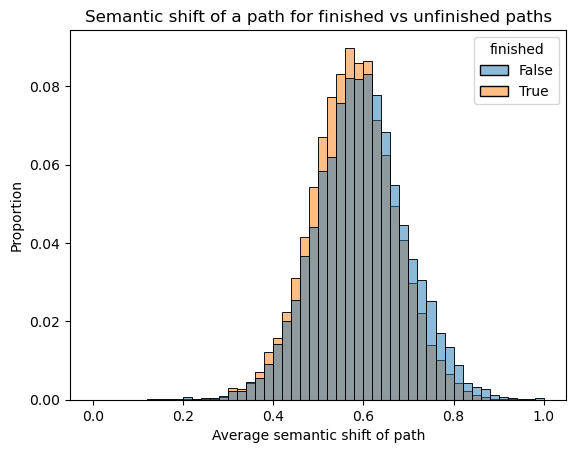

In [7]:
def CreateSemanticShiftList(row):
    path_list = row.resolved_path_list_name
    semantic_shift_list = []

    for i in range(len(path_list) - 1):
        semantic_similarity = SemanticSimilarity(path_list[i], path_list[i+1])
        # we want the shift, how different the two articles so take 1 - similarity
        semantic_shift_list.append(1 - semantic_similarity)
    
    return semantic_shift_list

df_paths["path_semantic_shift"] = df_paths.apply(lambda row: CreateSemanticShiftList(row), axis = 1)
df_paths["average_semantic_shift"] = df_paths["path_semantic_shift"].apply(lambda path: statistics.mean(path) if len(path) > 1 else np.nan)

average_semantic_shift_pf = df_paths[df_paths["finished"] == True]["average_semantic_shift"]
average_semantic_shift_pf = [x for x in average_semantic_shift_pf if ~np.isnan(x)]

average_semantic_shift_uf = df_paths[df_paths["finished"] == False]["average_semantic_shift"]
average_semantic_shift_uf = [x for x in average_semantic_shift_uf if ~np.isnan(x)]

print(f"Semantic shift (finished paths): mean = {statistics.mean(average_semantic_shift_pf):.4f} median = {statistics.median(average_semantic_shift_pf):.4f}")
print(f"Semantic shift (unfinished paths): mean = {statistics.mean(average_semantic_shift_uf):.4f} median = {statistics.median(average_semantic_shift_uf):.4f}")
pval = ttest_ind(average_semantic_shift_pf, average_semantic_shift_uf).pvalue
print("P-value = {} so the semantic shift between finished and unfinished paths is significantly different???????".format(pval))

sns.histplot(data=df_paths, x="average_semantic_shift", hue="finished", multiple="layer", binwidth=0.02, binrange=[0,1], stat="proportion", common_norm = False).set(title = "Semantic shift of a path for finished vs unfinished paths", xlabel = "Average semantic shift of path")
plt.show()

We can see that semantic shift along finished paths is smaller than for unfinished paths, which means finished paths tend to follow more closely related articles than unfinished paths.

In [8]:
def CreateSemanticSimilarityList(row):
    path_list = row.resolved_path_list_name
    similarity_list = []

    for article in path_list:
        similarity = SemanticSimilarity(article, row.target_link)
    
        similarity_list.append(similarity)
    
    return similarity_list

df_paths["path_similarity"] = df_paths.apply(lambda row: CreateSemanticSimilarityList(row), axis = 1)
df_paths["average_similarity"] = df_paths["path_similarity"].apply(lambda path: statistics.mean(path) if len(path) > 0 else np.nan)


Cannot find simlarity between Black pepper and Long peper
Cannot find simlarity between Fruit and Long peper
Cannot find simlarity between Botany and Long peper
Cannot find simlarity between Star Trek and Test
Cannot find simlarity between Star Trek  Deep Space Nine and Test
Cannot find simlarity between Star Trek and Test
Cannot find simlarity between World War II and Adolph Hitler
Cannot find simlarity between Marco Polo and Netbook
Cannot find simlarity between Watercolor painting and Podcast
Cannot find simlarity between 20th century and Podcast
Cannot find simlarity between Internet and Podcast
Cannot find simlarity between Music and Podcast
Cannot find simlarity between Sound and Podcast
Cannot find simlarity between Andrew Jackson and Christmas
Cannot find simlarity between Spain and Christmas
Cannot find simlarity between Latin and Christmas
Cannot find simlarity between Roman Catholic Church and Christmas
Cannot find simlarity between Jesus and Christmas
Cannot find simlarity 

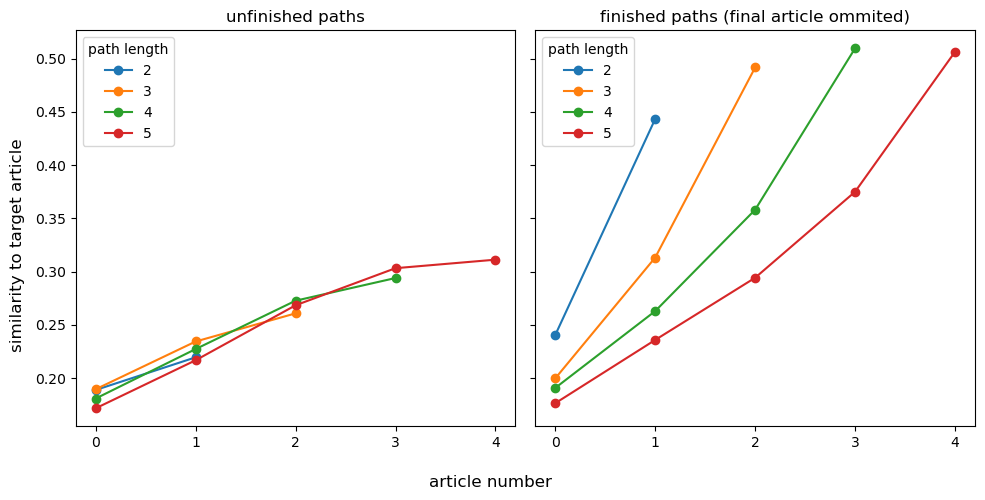

In [9]:
max_length = 5

df_uf_similarity = pd.DataFrame(index = [x for x in range (2, max_length + 1)], columns = [x for x in range (0, max_length)])
df_pf_similarity = pd.DataFrame(index = [x for x in range (2, max_length + 1)], columns = [x for x in range (0, max_length)])

for length in range (2, max_length + 1):
    similarities = df_paths.loc[(df_paths["finished"] == False) & (df_paths["n_click"] == length)]["path_similarity"].tolist()
    similarities = np.nanmean(np.array(similarities), axis=0).tolist()
    similarities += [np.nan] * (max_length - length)
    df_uf_similarity.iloc[length - 2] = similarities

    similarities = df_paths.loc[(df_paths["finished"] == True) & (df_paths["n_click"] == length + 1)]["path_similarity"].tolist()
    # remove last node, always max semantic similarity because reached target
    similarities = [x[:-1] for x in similarities]
    similarities = np.nanmean(np.array(similarities), axis=0).tolist()
    similarities += [np.nan] * (max_length - length)
    df_pf_similarity.iloc[length - 2] = similarities


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.supxlabel("article number")
fig.supylabel("similarity to target article")

y = [x for x in range (max_length)]
len_path = 2
for it, row in df_uf_similarity.iterrows():
    axs[0].plot(y, row, marker = "o", label = len_path)
    axs[0].set_title("unfinished paths")
    axs[0].legend(title="path length", loc = "upper left")
    axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))
    len_path += 1

len_path = 2
y = [x for x in range (max_length)]
for it, row in df_pf_similarity.iterrows():
    axs[1].plot(y, row, marker = "o", label = len_path)
    axs[1].set_title("finished paths (final article ommited)")
    axs[1].legend(title="path length", loc = "upper left")
    axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))
    len_path += 1

fig.tight_layout()

We see a clear difference between the finished and unfinished paths, unsfinished paths stagnating to around 0.3 semantic similarity to the target before being abandonned, while finished paths being at 0.5 similarity to the target on the article before the target.
We can also observe that paths which finish in a shorter number of articles on average start at a semantically closer article to the target.